In [1]:
from IPython.core.display import display, HTML
import scipy.constants as sc
from scipy.optimize import fsolve
from ipywidgets import interact, widgets
%matplotlib notebook

import numpy as np
import cmath
import matplotlib.pyplot as plt
import scipy.constants as sc
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath} \boldmath"
})
import os
import h5py

print(os.getpid())
%cd ../

14307
/media/work/docs/codes/QuCF/scripts-py


In [2]:
import pylib.mix as mix
from matplotlib import ticker
import time

path_ = "../results/LKW-1D-results/"
colors_ = ['b', 'r', 'g', 'gray', 'orange']

# cmap = 'seismic'
# cmap = 'bwr'
# cmap = 'jet'
# cmap = 'coolwarm'
cmap_one_sign_ = 'YlGn'
cmap_two_signs_= 'coolwarm'
def fmt_(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [3]:
# ---------------------------------------------------
# --- For reading results ---
# ---------------------------------------------------
def read_results(fname_loc):
    dd = {}
    fname = path_ + "/" + fname_loc
    dd["fname"] = fname
    
    print(f"Reading the file {fname}...")
    with h5py.File(fname, "r") as f:
        # ---
        bg           = f["basic"]
        flag_copies = bg["flag-copies"][()]
        date_sim    = bg["date-of-simulation"][()].decode("utf-8")
        # ---
        bg = f["parameters"]
        w = bg["w"][()]
        xs  = bg["source_x0"][()]
        dxs = bg["source_dx"][()] 
        # ---
        bg = f["grids"]
        x = np.array(bg["x"])
        v = np.array(bg["v"])
        Nx = len(x)
        Nv = len(v)
        # ---
        bg = f["result"]
        psi = np.array(bg["psi"])

    print("date of the simulation: ", date_sim)
    
    if flag_copies:
        print("case with copies of E")
    else:
        print("case without copies of E")
        
    print("Nx, Nv: {:d}, {:d}".format(Nx,Nv))

    N_var = Nx*Nv
    dd["g"] = np.zeros((Nx,Nv), dtype=np.complex)
    dd["E"] = np.zeros(Nx, dtype=np.complex)
    for ix in range(Nx):
        vE = psi[ix*Nv + N_var]
        dd["E"][ix] = np.complex(vE[0], vE[1])
        for iv in range(Nv):
            vg = psi[ix*Nv+iv]
            dd["g"][ix,iv] = np.complex(vg[0], vg[1])
            
    dd.update({
        "x": x, "v": v,
        "Nx": Nx, "Nv": Nv,
        "nx": int(np.log2(Nx)), "nv": int(np.log2(Nv)),
        "flag-copies": flag_copies,
        "w": w, 
        "source-x0": xs, "source-dx": dxs
    })
    return dd


# -----------------------------------------------------------------
# --- For plotting ---
# -----------------------------------------------------------------
def plot_results_one(dd):
    # --- distribution function ---
    XX, YY = np.meshgrid(dd["v"], dd["x"])
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cs = ax.contourf(XX, YY, np.real(dd["g"]), levels=100, cmap=cmap_two_signs_)
    fig.colorbar(cs, ax = ax, format=ticker.FuncFormatter(fmt_))
    ax.set_xlabel('$v$')
    ax.set_ylabel('$x$')
    ax.set_title('Re[g]')
    
    fig_gxv = plt.figure()
    ax = fig_gxv.add_subplot(111)
    cs = ax.contourf(XX, YY, np.imag(dd["g"]), levels=100, cmap=cmap_two_signs_)
    fig.colorbar(cs, ax = ax, format=ticker.FuncFormatter(fmt_))
    ax.set_xlabel('$v$')
    ax.set_ylabel('$x$')
    ax.set_title('Im[g]')

    # --- electric field ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(dd["x"], np.real(dd["E"]), color='b', linewidth = 2, linestyle='-', label="Re[E]")
    ax.plot(dd["x"], np.imag(dd["E"]), color='r', linewidth = 2, linestyle='--', label="Im[E]")
    plt.xlabel('$x$')
    plt.ylabel("E")
    ax.legend()
    plt.grid(True)
    plt.show()
    
    return fig_gxv
    
def compare_E(dds):
    N_sims = len(dds)
    
    fig_re = plt.figure()
    ax = fig_re.add_subplot(111)
    for ii in range(N_sims):
        dd = dds[ii]
        ax.plot(
            dd["x"], np.real(dd["E"]), 
            color=colors_[ii], 
            linewidth = 2, linestyle='-', 
            label="nx = {:d}, nv = {:d}, w = {:0.3f}".format(dd["nx"], dd["nv"], dd["w"])
        )
        del dd
    plt.xlabel('$x$')
    plt.ylabel("Re[E]")
    ax.legend()
    plt.grid(True)
    plt.show()
    
    fig_im = plt.figure()
    ax = fig_im.add_subplot(111)
    for ii in range(N_sims):
        dd = dds[ii]
        ax.plot(
            dd["x"], np.imag(dd["E"]), 
            color=colors_[ii], 
            linewidth = 2, linestyle='-', 
            label="nx = {:d}, nv = {:d}, w = {:0.3f}".format(dd["nx"], dd["nv"], dd["w"])
        )
        del dd
    plt.xlabel('$x$')
    plt.ylabel("Im[E]")
    ax.legend()
    plt.grid(True)
    plt.show()
    
    return fig_re, fig_im
    
    
def compare_g_v1(dds, v1):
    N_sims = len(dds)
    
    ids_v1 = np.zeros(N_sims)
    
    for ii in range(N_sims):
        dd = dds[ii]
        ids_v1[ii], _ = mix.find(dd["v"], v1)
        del dd
        
    print(ids_v1)
    
    fig_re = plt.figure()
    ax = fig_re.add_subplot(111)
    for ii in range(N_sims):
        dd = dds[ii]
        id_v1 = int(ids_v1[ii])
        ax.plot(
            dd["x"], np.real(dd["g"][:,id_v1]), 
            color=colors_[ii], 
            linewidth = 2, linestyle='-', 
            label="nx = {:d}, nv = {:d}, w={:0.3} at v1 = {:0.3f}".format(
                dd["nx"], dd["nv"], dd["w"], dd["v"][id_v1]
            )
        )
        del dd, id_v1
    plt.xlabel('$x$')
    plt.ylabel("Re[g]")
    ax.legend()
    plt.grid(True)
    plt.show()
    
    fig_im = plt.figure()
    ax = fig_im.add_subplot(111)
    for ii in range(N_sims):
        dd = dds[ii]
        id_v1 = int(ids_v1[ii])
        ax.plot(
            dd["x"], np.imag(dd["g"][:,id_v1]), 
            color=colors_[ii], 
            linewidth = 2, linestyle='-', 
            label="nx = {:d}, nv = {:d}, w={:0.3} at v1 = {:0.3f}".format(
                dd["nx"], dd["nv"], dd["w"], dd["v"][id_v1]
            )
        )
        del dd, id_v1
    plt.xlabel('$x$')
    plt.ylabel("Im[g]")
    ax.legend()
    plt.grid(True)
    plt.show()
    
    return fig_re, fig_im

In [31]:
# ---------------------------------------------------
# --- Read results ---
# ---------------------------------------------------
dd_1  = read_results("out_7_5_w1.05_Lx8_Lv4_flat.hdf5"); print()







Reading the file ../results/LKW-1D-results//out_8_6_w1.01_woc_flat_form1_outgoing.hdf5...
date of the simulation:  04-20-2023 16:35:08
case without copies of E
Nx, Nv: 256, 64

Reading the file ../results/LKW-1D-results//out_8_6_w1.1_woc_flat_form1_outgoing.hdf5...
date of the simulation:  04-20-2023 16:44:12
case without copies of E
Nx, Nv: 256, 64



In [ ]:
# ---------------------------------------------------
# --- Save plots---
# ---------------------------------------------------
# fig_gxv_1.savefig('/media/work/docs/codes/QuCF/results/LKW-1D-results/report-04-20-2023/' + "/gxv-w04.png")
# fig_gxv_2.savefig('/media/work/docs/codes/QuCF/results/LKW-1D-results/report-04-20-2023/' + "/gxv-w4.png")

# fig_nv_re.savefig('/media/work/docs/codes/QuCF/results/LKW-1D-results/report-04-20-2023/' + "/Er.png")
# fig_nv_im.savefig('/media/work/docs/codes/QuCF/results/LKW-1D-results/report-04-20-2023/' + "/Ei.png")

# fig_gre_vp.savefig('/media/work/docs/codes/QuCF/results/LKW-1D-results/report-04-20-2023/' + "/gx_re_vp.png")
# fig_gim_vp.savefig('/media/work/docs/codes/QuCF/results/LKW-1D-results/report-04-20-2023/' + "/gx_im_vp.png")
# fig_gre_vn.savefig('/media/work/docs/codes/QuCF/results/LKW-1D-results/report-04-20-2023/' + "/gx_re_vn.png")
# fig_gim_vn.savefig('/media/work/docs/codes/QuCF/results/LKW-1D-results/report-04-20-2023/' + "/gx_im_vn.png")

<IPython.core.display.Javascript object>


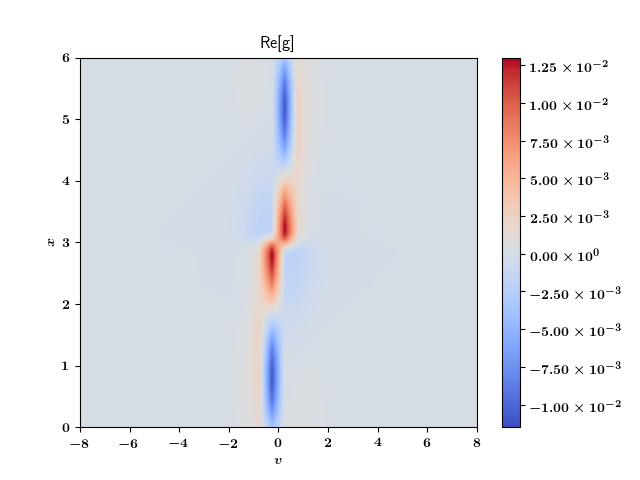

<IPython.core.display.Javascript object>


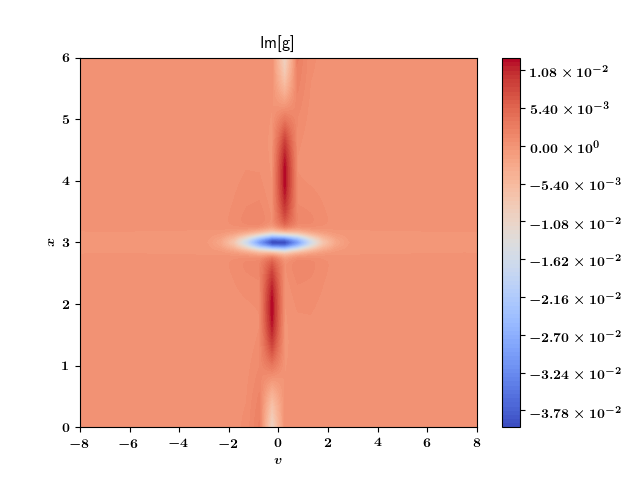

<IPython.core.display.Javascript object>


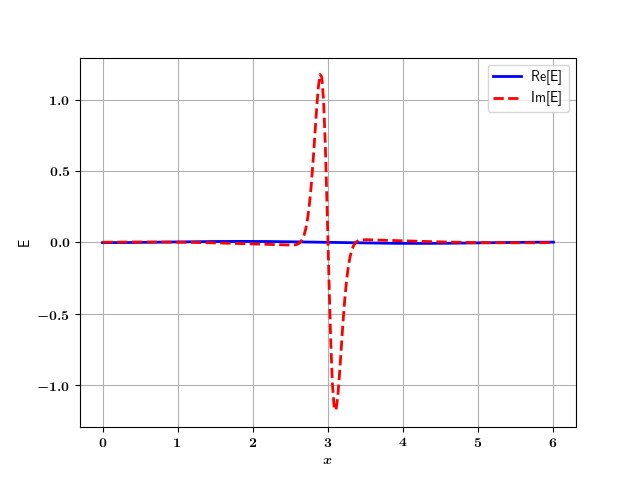

<IPython.core.display.Javascript object>


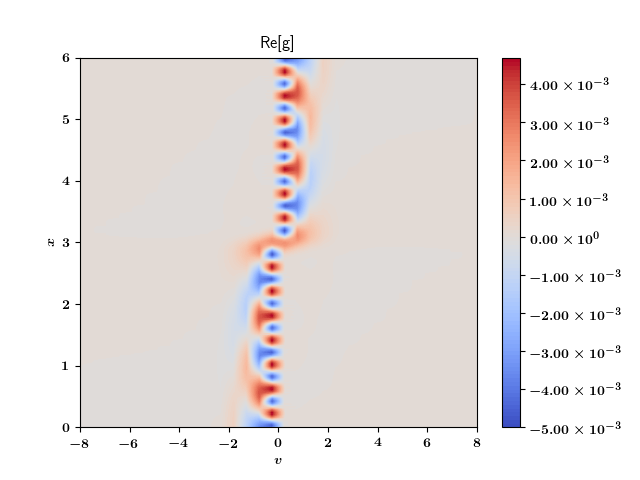

<IPython.core.display.Javascript object>


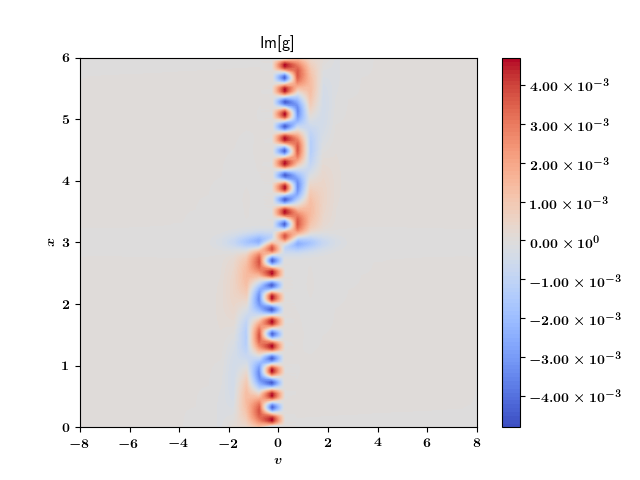

<IPython.core.display.Javascript object>


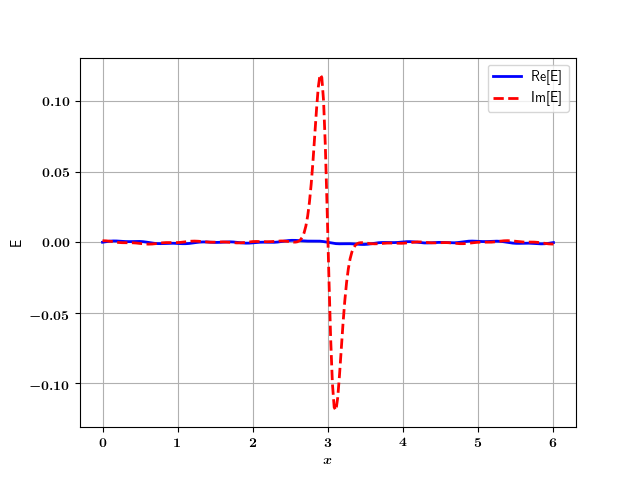

In [7]:
# ---------------------------------------------------
# --- one sim.: g[x,v], E(x) ---
# ---------------------------------------------------
fig_gxv_1 = plot_results_one(dd_w04_85_flat)
fig_gxv_2 = plot_results_one(dd_w4_85_flat)

<IPython.core.display.Javascript object>


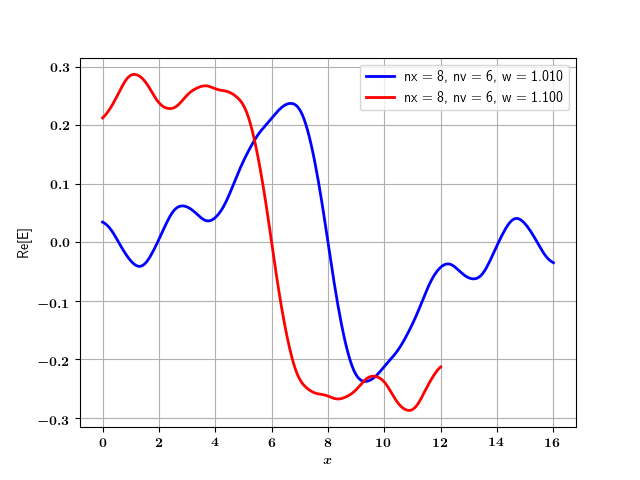

<IPython.core.display.Javascript object>


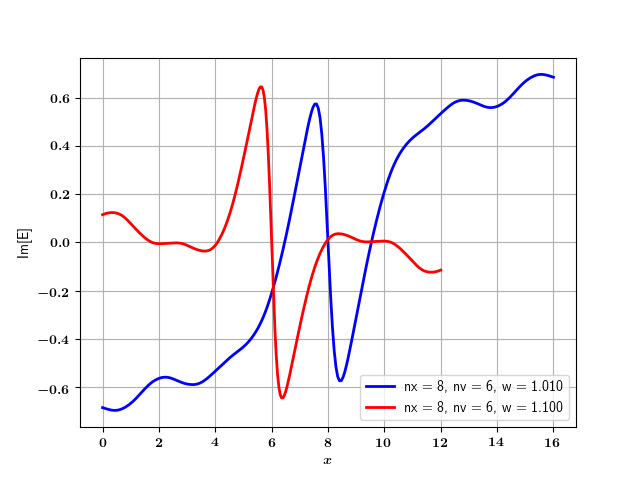

In [32]:
# ---------------------------------------------------
# --- Compare electric field ---
# ---------------------------------------------------
fig_nv_re, fig_nv_im = compare_E([dd_1])

[33. 33.]


<IPython.core.display.Javascript object>


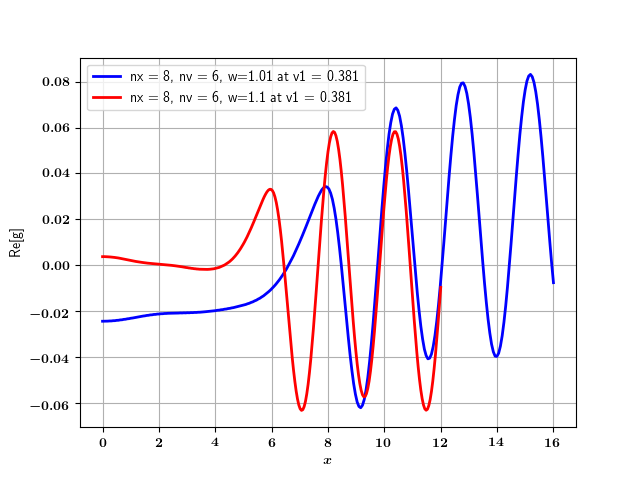

<IPython.core.display.Javascript object>


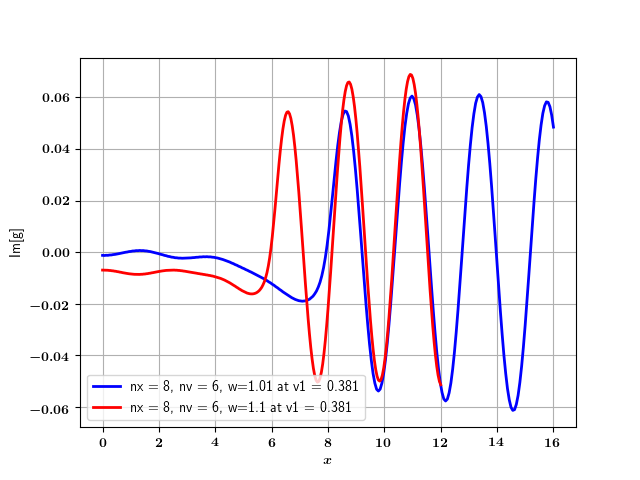

In [33]:
# ---------------------------------------------------
# --- Compare distribution function ---
# ---------------------------------------------------
v1 = 0.258
# v1 = 0.774

# compare_g_v1([dd_w04_85_tanh, dd_w4_85_tanh], v1)

# fig_gre_vp, fig_gim_vp = compare_g_v1([dd_w04_85_flat, dd_w4_85_flat], v1)
# fig_gre_vn, fig_gim_vn = compare_g_v1([dd_w04_85_flat, dd_w4_85_flat], -v1-0.001)

fig_gre_vp, fig_gim_vp = compare_g_v1([dd, dd_2], v1)

del v1

<IPython.core.display.Javascript object>


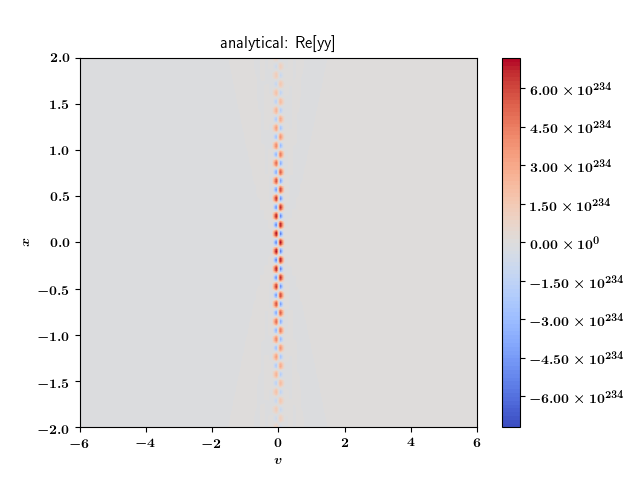

<IPython.core.display.Javascript object>


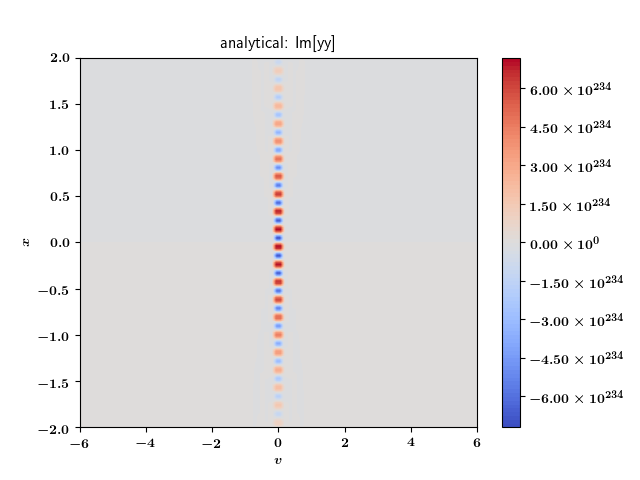

In [10]:
def test_functions():
    w = 2
    xs, ds = 0.0, 1.0
    
    Nx, Nv = 201, 100
    x = np.linspace(-2., 2., Nx)
    v = np.linspace(-6.0, 6.0, Nv)
    
    yy = np.zeros((Nx, Nv), dtype = np.complex)
    for ix in range(Nx):
        x1 = x[ix]
        shx = x1 - xs
        for iv in range(Nv):
            v1 = v[iv]
            k1 = w / v1
            
            y1 = -1j * shx/(np.sqrt(2) * ds) +  ds * k1/np.sqrt(2)
            yy[ix,iv] = special.erfi(y1)
            
    # --- plot distribution function ---
    XX, YY = np.meshgrid(v, x)
    
    # real parts
    fig_g_analy_re = plt.figure()
    ax = fig_g_analy_re.add_subplot(111)
    cs = ax.contourf(XX, YY, np.real(yy), levels=100, cmap=cmap_two_signs_)
    fig_g_analy_re.colorbar(cs, ax = ax, format=ticker.FuncFormatter(fmt_))
    ax.set_xlabel('$v$')
    ax.set_ylabel('$x$')
    ax.set_title('analytical: Re[yy]')
    
    # imaginary parts
    fig_g_analy_im = plt.figure()
    ax = fig_g_analy_im.add_subplot(111)
    cs = ax.contourf(XX, YY, np.imag(yy), levels=100, cmap=cmap_two_signs_)
    fig_g_analy_im.colorbar(cs, ax = ax, format=ticker.FuncFormatter(fmt_))
    ax.set_xlabel('$v$')
    ax.set_ylabel('$x$')
    ax.set_title('analytical: Im[yy]')
    
    return

test_functions()

w =  2.0
nx, nv = 8, 7


<IPython.core.display.Javascript object>


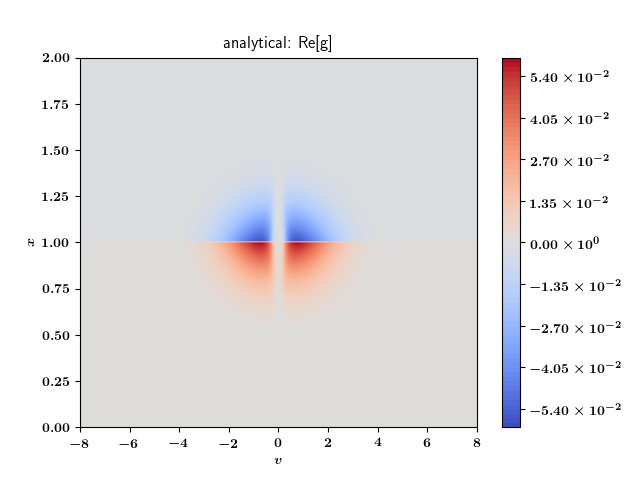

<IPython.core.display.Javascript object>


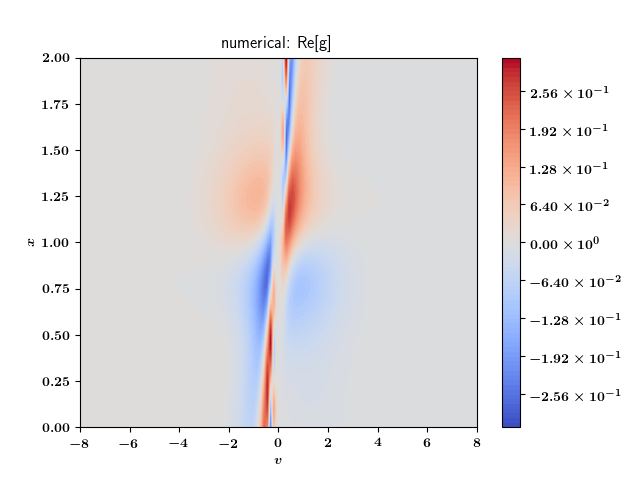

<IPython.core.display.Javascript object>


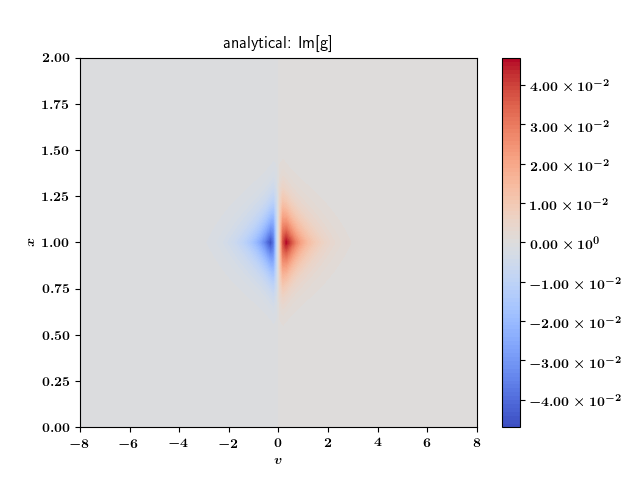

<IPython.core.display.Javascript object>


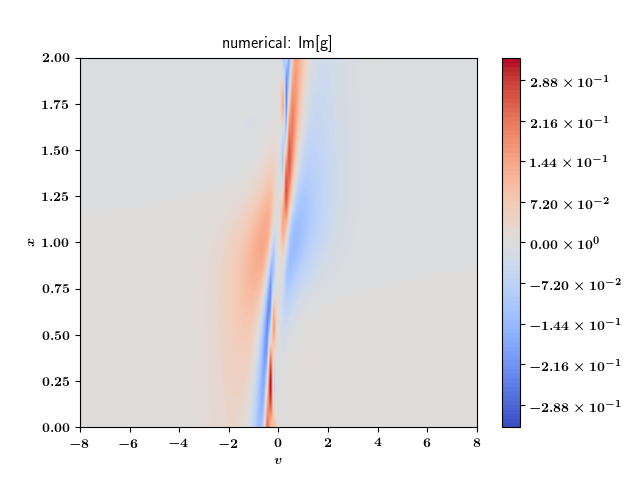

<IPython.core.display.Javascript object>


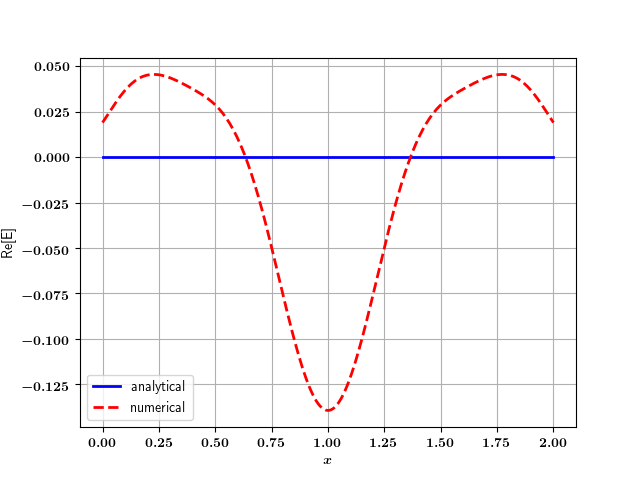

<IPython.core.display.Javascript object>


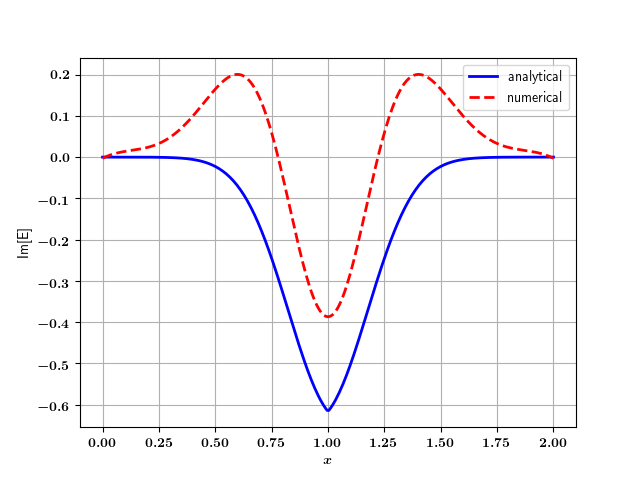

In [9]:
# ---------------------------------------------------
# --- Analytical solution: with Gaussian-source ---
# ---------------------------------------------------
from scipy import special
def compare_analytical(dd):
    w = dd["w"]
    xs = dd["source-x0"]
    ds = dd["source-dx"]
    
    x = dd["x"]
    v = dd["v"]
    
    Nx = len(x)
    Nv = len(v)
    
    print("w = ", w)
    
    G = np.sqrt( 1./np.sqrt(2*np.pi) * np.exp(-v**2/2.) )
    
    g = np.zeros((Nx,Nv), dtype=np.complex)
    E = np.zeros(Nx, dtype=np.complex)
    
    coef_constant = np.pi**(0.25) * ds / (2.**(3./4) * w)
    for ix in range(Nx):
        x1 = x[ix]
        shx = x1 - xs
        for iv in range(Nv):
            v1 = v[iv]
            k1 = w / v1
            
            y1 = -1j * shx/(np.sqrt(2) * ds) +  ds * k1/np.sqrt(2)
            temp = np.exp(1j*k1*shx) * np.exp(-ds**2 * k1**2/2.) * np.exp(-v1**2/4.)
            
            if x1 < xs:
                g[ix,iv] = coef_constant * temp * (1j * special.erfi(y1) + 1)
            else:
                g[ix,iv] = coef_constant * temp * (1j * special.erfi(y1) - 1) 
            
#             g[ix,iv] = coef_constant * temp * 1j * special.erfi(y1)
 
        E[ix] = - np.trapz(v*G*g[ix,:]) / w + np.exp(-shx**2/(2.*ds**2)) / (1j*w)
    
#     for ix in range(Nx):
#         x1 = x[ix]
#         for iv in range(Nv):
#             v1 = v[iv]
            
#             y1 = (-1j * v1 * (x1 - xs) + ws**2 * w) / (np.sqrt(2) * v1 * ws) 
            
#             temp = 1j * np.exp( 1j*x1*w/v1 - w*(2j*v1*xs + ws**2 * w)/(2*v1**2) )
#             temp = temp * np.sqrt(np.exp(-v1**2/2)) * np.pi**(0.25) * ws * special.erfi(y1)
#             temp = temp / (2**(3./4) * w)
            
#             g[ix,iv] = temp
#         E[ix] = - np.trapz(v*G*g[ix,:])/w + 1./(1j*w) * np.exp(-(x1-xs)**2/(2*ws**2))
            
    
    # --- print some parameters ---
    print("nx, nv = {:d}, {:d}".format(dd["nx"], dd["nv"]))
    
    # --- plot distribution function ---
    XX, YY = np.meshgrid(v, x)
    
    # real parts
    fig_g_analy_re = plt.figure()
    ax = fig_g_analy_re.add_subplot(111)
    cs = ax.contourf(XX, YY, np.real(g), levels=100, cmap=cmap_two_signs_)
    fig_g_analy_re.colorbar(cs, ax = ax, format=ticker.FuncFormatter(fmt_))
    ax.set_xlabel('$v$')
    ax.set_ylabel('$x$')
    ax.set_title('analytical: Re[g]')
    
    fig_g_num_re = plt.figure()
    ax = fig_g_num_re.add_subplot(111)
    cs = ax.contourf(XX, YY, np.real(dd["g"]), levels=100, cmap=cmap_two_signs_)
    fig_g_num_re.colorbar(cs, ax = ax, format=ticker.FuncFormatter(fmt_))
    ax.set_xlabel('$v$')
    ax.set_ylabel('$x$')
    ax.set_title('numerical: Re[g]')
    
    # imaginary parts
    fig_g_analy_im = plt.figure()
    ax = fig_g_analy_im.add_subplot(111)
    cs = ax.contourf(XX, YY, np.imag(g), levels=100, cmap=cmap_two_signs_)
    fig_g_analy_im.colorbar(cs, ax = ax, format=ticker.FuncFormatter(fmt_))
    ax.set_xlabel('$v$')
    ax.set_ylabel('$x$')
    ax.set_title('analytical: Im[g]')
    
    fig_g_num_im = plt.figure()
    ax = fig_g_num_im.add_subplot(111)
    cs = ax.contourf(XX, YY, np.imag(dd["g"]), levels=100, cmap=cmap_two_signs_)
    fig_g_num_im.colorbar(cs, ax = ax, format=ticker.FuncFormatter(fmt_))
    ax.set_xlabel('$v$')
    ax.set_ylabel('$x$')
    ax.set_title('numerical: Im[g]')
    
    # --- plot electric field ---
    
    # real parts
    fig_E_re = plt.figure()
    ax = fig_E_re.add_subplot(111)
    ax.plot(x, np.real(E),       color='b', linewidth = 2, linestyle='-', label="analytical")
    ax.plot(x, np.real(dd["E"]), color='r', linewidth = 2, linestyle='--', label="numerical")
    plt.xlabel('$x$')
    plt.ylabel("Re[E]")
    ax.legend()
    plt.grid(True)
    plt.show()
    
    # imaginary parts
    fig_E_im = plt.figure()
    ax = fig_E_im.add_subplot(111)
    ax.plot(x, np.imag(E),       color='b', linewidth = 2, linestyle='-', label="analytical")
    ax.plot(x, np.imag(dd["E"]), color='r', linewidth = 2, linestyle='--', label="numerical")
    plt.xlabel('$x$')
    plt.ylabel("Im[E]")
    ax.legend()
    plt.grid(True)
    plt.show()
    
    return fig_g_analy_re, fig_g_num_re, fig_g_analy_im, fig_g_num_im, fig_E_re, fig_E_im


fig_g_analy_re, fig_g_num_re, fig_g_analy_im, fig_g_num_im, fig_E_re, fig_E_im = compare_analytical(dd_20)

# fig_g_analy_re.savefig('/media/work/docs/codes/QuCF/results/LKW-1D-results/temp/' + "/g_analy_re.eps")
# fig_g_num_re.savefig('/media/work/docs/codes/QuCF/results/LKW-1D-results/temp/' + "/g_num_re.eps")
# fig_g_analy_im.savefig('/media/work/docs/codes/QuCF/results/LKW-1D-results/temp/' + "/g_analy_im.eps")
# fig_g_num_im.savefig('/media/work/docs/codes/QuCF/results/LKW-1D-results/temp/' + "/g_num_im.eps")

# fig_E_re.savefig('/media/work/docs/codes/QuCF/results/LKW-1D-results/temp/' + "/E_re_comp_analy_num.eps")
# fig_E_im.savefig('/media/work/docs/codes/QuCF/results/LKW-1D-results/temp/' + "/E_im_comp_analy_num.eps")

In [7]:
# ---------------------------------------------------
# --- Analytical solution: with Delta-source ---
# ---------------------------------------------------
from scipy import special
def compare_analytical(dd):
    w = dd["w"]
    xs = dd["source-x0"]
    
    x = dd["x"]
    v = dd["v"]
    
    Nx = len(x)
    Nv = len(v)
    
    G = np.sqrt( 1./np.sqrt(2*np.pi) * np.exp(-v**2/2.) )
    
    g = np.zeros((Nx,Nv), dtype=np.complex)
    E = np.zeros(Nx, dtype=np.complex)
    for ix in range(Nx):
        x1 = x[ix]
        for iv in range(Nv):
            v1 = v[iv]
            k1 = w/v1
               
            temp = ( np.exp(1j*k1*(x1-xs)) * np.exp(-v1**2/4.) ) / ((2*np.pi)**(1./4) * w)
            
            if v1 < 0:
                g[ix,iv] = temp * (np.heaviside(x1-xs,1.)-1)
            if v1 > 0:
                g[ix,iv] = temp * np.heaviside(x1-xs,1.)
        E[ix] = - np.trapz(v*G*g[ix,:])/w
            
    
    # --- print some parameters ---
    print("nx, nv = {:d}, {:d}".format(dd["nx"], dd["nv"]))
    
    # --- plot distribution function ---
    XX, YY = np.meshgrid(v, x)
    
    # real parts
    fig_g_analy_re = plt.figure()
    ax = fig_g_analy_re.add_subplot(111)
    cs = ax.contourf(XX, YY, np.real(g), levels=100, cmap=cmap_two_signs_)
    fig_g_analy_re.colorbar(cs, ax = ax, format=ticker.FuncFormatter(fmt_))
    ax.set_xlabel('$v$')
    ax.set_ylabel('$x$')
    ax.set_title('analytical: Re[g]')
    
    fig_g_num_re = plt.figure()
    ax = fig_g_num_re.add_subplot(111)
    cs = ax.contourf(XX, YY, np.real(dd["g"]), levels=100, cmap=cmap_two_signs_)
    fig_g_num_re.colorbar(cs, ax = ax, format=ticker.FuncFormatter(fmt_))
    ax.set_xlabel('$v$')
    ax.set_ylabel('$x$')
    ax.set_title('numerical: Re[g]')
    
    # imaginary parts
    fig_g_analy_im = plt.figure()
    ax = fig_g_analy_im.add_subplot(111)
    cs = ax.contourf(XX, YY, np.imag(g), levels=100, cmap=cmap_two_signs_)
    fig_g_analy_im.colorbar(cs, ax = ax, format=ticker.FuncFormatter(fmt_))
    ax.set_xlabel('$v$')
    ax.set_ylabel('$x$')
    ax.set_title('analytical: Im[g]')
    
    fig_g_num_im = plt.figure()
    ax = fig_g_num_im.add_subplot(111)
    cs = ax.contourf(XX, YY, np.imag(dd["g"]), levels=100, cmap=cmap_two_signs_)
    fig_g_num_im.colorbar(cs, ax = ax, format=ticker.FuncFormatter(fmt_))
    ax.set_xlabel('$v$')
    ax.set_ylabel('$x$')
    ax.set_title('numerical: Im[g]')
    
    # --- plot electric field ---
    
    # real parts
    fig_E_re = plt.figure()
    ax = fig_E_re.add_subplot(111)
    ax.plot(x, np.real(E),       color='b', linewidth = 2, linestyle='-', label="analytical")
    ax.plot(x, np.real(dd["E"]), color='r', linewidth = 2, linestyle='--', label="numerical")
    plt.xlabel('$x$')
    plt.ylabel("Re[E]")
    ax.legend()
    plt.grid(True)
    plt.show()
    
    # imaginary parts
    fig_E_im = plt.figure()
    ax = fig_E_im.add_subplot(111)
    ax.plot(x, np.imag(E),       color='b', linewidth = 2, linestyle='-', label="analytical")
    ax.plot(x, np.imag(dd["E"]), color='r', linewidth = 2, linestyle='--', label="numerical")
    plt.xlabel('$x$')
    plt.ylabel("Im[E]")
    ax.legend()
    plt.grid(True)
    plt.show()
    
    return fig_g_analy_re, fig_g_num_re, fig_g_analy_im, fig_g_num_im, fig_E_re, fig_E_im


fig_g_analy_re, fig_g_num_re, fig_g_analy_im, fig_g_num_im, fig_E_re, fig_E_im = compare_analytical(dd_05)

# fig_g_analy_re.savefig('/media/work/docs/codes/QuCF/results/LKW-1D-results/temp/' + "/g_analy_re.eps")
# fig_g_num_re.savefig('/media/work/docs/codes/QuCF/results/LKW-1D-results/temp/' + "/g_num_re.eps")
# fig_g_analy_im.savefig('/media/work/docs/codes/QuCF/results/LKW-1D-results/temp/' + "/g_analy_im.eps")
# fig_g_num_im.savefig('/media/work/docs/codes/QuCF/results/LKW-1D-results/temp/' + "/g_num_im.eps")

# fig_E_re.savefig('/media/work/docs/codes/QuCF/results/LKW-1D-results/temp/' + "/E_re_comp_analy_num.eps")
# fig_E_im.savefig('/media/work/docs/codes/QuCF/results/LKW-1D-results/temp/' + "/E_im_comp_analy_num.eps")

nx, nv = 8, 7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
# ---------------------------------------------------
# --- Dense solver ---
# ---------------------------------------------------
def read_matrix_and_rhs(dd):   
    # read the matrix:
    ddA = {}
    with h5py.File(dd["fname"], "r") as f:
        bg = f["matrices"]
        ddA["N"]       = bg["A-N"][()]
        ddA["Nnz"]     = bg["A-Nnz"][()]
        ddA["columns"] = bg["A-columns"][()]
        ddA["rows"]    = bg["A-rows"][()]
        temp_array     = bg["A-values"][()] 
        
        bg = f["profiles"]
        b_temp = np.array(bg["b"])
        
    ddA["values"] = np.zeros(ddA["Nnz"], dtype=np.complex)
    for ii in range(len(temp_array)):
        v = temp_array[ii]
        ddA["values"][ii] = np.complex(v[0], v[1])
    
    # form the matrix:
    N = ddA["N"]
    A = np.zeros((N,N), dtype=np.complex)
    for ir in range(N):
        for i_nz in range(ddA["rows"][ir], ddA["rows"][ir+1]):
            A[ir, ddA["columns"][i_nz]] = ddA["values"][i_nz] 
    
    # form the right-hand-side vector:
    b = np.zeros(len(b_temp), dtype=np.complex)
    for ii in range(len(b_temp)):
        temp_v1 = b_temp[ii]
        b[ii] = np.complex(temp_v1[0], temp_v1[1])
    del b_temp, temp_v1
        
    return A, b

def dense_solver(dd):
    A, b = read_matrix_and_rhs(dd)
    
    A_inv = np.linalg.inv(A)
    psi = np.dot(A_inv, b)
    
    Nx = dd["Nx"]
    Nv = dd["Nv"]
    N_var = Nx*Nv
    
    g = np.zeros((Nx,Nv), dtype=np.complex)
    E = np.zeros(Nx, dtype=np.complex)
    for ix in range(Nx):
        E[ix] = psi[ix*Nv + N_var]
        for iv in range(Nv):
            g[ix,iv] = psi[ix*Nv+iv]
    return g, E

# ------------------------------------------------
# --- Solve the system by the dense solver ---
# ------------------------------------------------
start = time.perf_counter()
g_dens, E_dens = dense_solver(dd)
end   = time.perf_counter()
print("time for inv. calc.: {:0.3e} s".format(end - start))
    
del start, end

time for inv. calc.: 3.749e-02 s


<IPython.core.display.Javascript object>


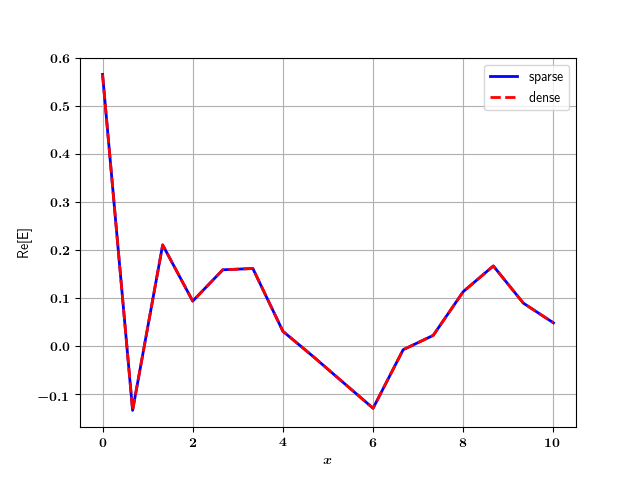

<IPython.core.display.Javascript object>


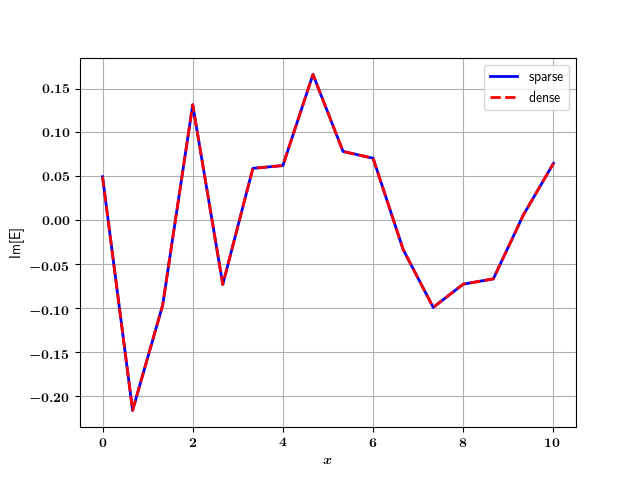

In [8]:
# ---------------------------------------------------------
# --- Compare results from the dense and sparse solvers ---
# ---------------------------------------------------------

# --- electric field ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(dd["x"], np.real(dd["E"]), color='b', linewidth = 2, linestyle='-', label="sparse")
ax.plot(dd["x"], np.real(E_dens),  color='r', linewidth = 2, linestyle='--', label="dense")
plt.xlabel('$x$')
plt.ylabel("Re[E]")
ax.legend()
plt.grid(True)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(dd["x"], np.imag(dd["E"]), color='b', linewidth = 2, linestyle='-', label="sparse")
ax.plot(dd["x"], np.imag(E_dens),  color='r', linewidth = 2, linestyle='--', label="dense")
plt.xlabel('$x$')
plt.ylabel("Im[E]")
ax.legend()
plt.grid(True)
plt.show()